In [7]:
import numpy as np

# This class represents a single node in the Modal Isolation Forest
class MIFNode:
    def __init__(self, depth=0, max_depth=10, min_size=1):
        self.depth = depth                 # Current depth of this node in the tree
        self.max_depth = max_depth         # Maximum allowed depth for the tree
        self.min_size = min_size           # Minimum number of samples required to allow further splitting

        self.left = None                   # Left child node
        self.right = None                  # Right child node

        self.split_vector = None           # Random direction vector used to split data
        self.threshold = None              # Threshold used to separate projected values
        self.modality = None               # Modality type: "X" (current), "EQ" (equality), or "Y" (next)

        self.is_leaf = False               # Flag indicating whether this node is a leaf
        self.size = 0                      # Number of samples in this node (used later for scoring)

    # Recursively build the tree structure from input data X
    def fit(self, X, modalities=["X", "EQ", "Y"], modality_probs=None):
        n_samples, n_features = X.shape
        self.size = n_samples

        # Check stopping conditions: max depth reached or not enough samples
        if self.depth >= self.max_depth or n_samples <= self.min_size:
            self.is_leaf = True
            return

        # Select modality type randomly (with or without given probabilities)
        if modality_probs is None:
            modality_probs = [1 / len(modalities)] * len(modalities)
        self.modality = np.random.choice(modalities, p=modality_probs)

        # For EQ modality, input needs to be extended to 2D
        proj_dim = 2 if self.modality == "EQ" else n_features
        self.split_vector = np.random.randn(proj_dim)              # Random split direction
        self.split_vector /= np.linalg.norm(self.split_vector)     # Normalize to unit vector

        # Project data according to selected modality
        if self.modality == "X":
            proj_data = X                                           # Use current value
        elif self.modality == "EQ":
            level = X                                               # Current value
            shifted = np.roll(X, 1, axis=0)                         # Shifted version (previous values)
            diff = np.abs(level - shifted)                          # Absolute difference from previous
            proj_data = np.hstack([level, diff])                    # Concatenate level and difference
            proj_data[0, 1] = 0                                     # No previous value for first row → set diff = 0
        elif self.modality == "Y":
            proj_data = np.roll(X, -1, axis=0)                      # Use next time point
        else:
            raise ValueError("Unknown modality:", self.modality)

        # Project all samples along the chosen direction
        projections = proj_data @ self.split_vector
        min_proj, max_proj = projections.min(), projections.max()

        # If all projections are equal → cannot split further
        if min_proj == max_proj:
            self.is_leaf = True
            return

        # Randomly pick a threshold between min and max projection
        self.threshold = np.random.uniform(min_proj, max_proj)

        # Split data based on threshold
        condition = projections < self.threshold
        left_X = X[condition]
        right_X = X[~condition]

        # If one side is empty → make this a leaf node
        if len(left_X) == 0 or len(right_X) == 0:
            self.is_leaf = True
            return

        # Create left and right child nodes and fit them recursively
        self.left = MIFNode(self.depth + 1, self.max_depth, self.min_size)
        self.left.fit(left_X, modalities, modality_probs)

        self.right = MIFNode(self.depth + 1, self.max_depth, self.min_size)
        self.right.fit(right_X, modalities, modality_probs)


# This class represents the entire MIF tree structure
class MIFTree:
    def __init__(self, max_depth=10, min_size=1, modalities=["X", "EQ", "Y"], modality_probs=None, seed=None):
        self.max_depth = max_depth               # Max tree depth
        self.min_size = min_size                 # Min samples for node splitting
        self.modalities = modalities             # Modalities to use
        self.modality_probs = modality_probs     # Probabilities for selecting modalities
        self.root = None                         # Root node of the tree
        self.seed = seed                         # Random seed (optional)

    # Build the MIF tree from data
    def fit(self, X):
        if self.seed is not None:
            np.random.seed(self.seed)

        self.root = MIFNode(
            depth=0,
            max_depth=self.max_depth,
            min_size=self.min_size
        )
        self.root.fit(X, modalities=self.modalities, modality_probs=self.modality_probs)

    # Calculate the path length of a sample through the tree
    def path_length(self, x, i, X, node=None, depth=0):
        if node is None:
            node = self.root

        if node.is_leaf:
            return depth

        # Prepare projection data for the current modality
        if node.modality == "X":
            proj = x
        elif node.modality == "EQ":
            if i == 0:
                proj = np.zeros((2,))  # No previous value available for first point
            else:
                level = X[i]
                diff = np.abs(X[i] - X[i - 1])
                proj = np.array([level, diff])
        elif node.modality == "Y":
            proj = x if i == len(X) - 1 else X[i + 1]  # Use next point, unless it's the last one
        else:
            raise ValueError("Unknown modality during traversal:", node.modality)

        # Project current sample and compare with threshold
        projection = np.dot(proj.flatten(), node.split_vector.flatten()).item()
        condition = projection < node.threshold

        # Traverse to the next node
        if condition:
            return self.path_length(x, i, X, node.left, depth + 1)
        else:
            return self.path_length(x, i, X, node.right, depth + 1)

    # Calculate anomaly scores for the entire dataset
    def anomaly_score(self, X):
        n = len(X)
        c_n = 2 * np.log(n - 1) + 0.5772156649  # Normalization constant (expected path length)
        scores = []
        for i, x in enumerate(X):
            pl = self.path_length(x, i, X)           # Compute path length for sample i
            score = 2 ** (-pl / c_n)                 # Isolation Forest scoring formula
            scores.append(score)
        return np.array(scores)

In [9]:
# This class builds multiple Modal Isolation Trees (MIFTree)
# and combines their outputs to form a more stable anomaly detector
class MIForest:
    def __init__(self, n_trees=50, max_depth=10, min_size=1,
                 modalities=["X", "EQ", "Y"], modality_probs=None, seed=None):
        self.n_trees = n_trees                    # Number of trees to build
        self.trees = []                           # List to store trained trees
        self.max_depth = max_depth                # Maximum depth for each tree
        self.min_size = min_size                  # Minimum samples to allow a split
        self.modalities = modalities              # Modalities to use in the splits
        self.modality_probs = modality_probs      # Probability distribution over modalities
        self.seed = seed                          # Seed for reproducibility (optional)

    # Build all trees in the forest
    def fit(self, X):
        self.trees = []                           # Clear previous trees (if any)
        for i in range(self.n_trees):
            if self.seed is not None:
                np.random.seed(self.seed + i)     # Use a different seed for each tree

            # Create a new MIFTree with possibly different modality splits
            tree = MIFTree(
                max_depth=self.max_depth,
                min_size=self.min_size,
                modalities=self.modalities,
                modality_probs=self.modality_probs,
                seed=self.seed + i                # Ensure different randomness in each tree
            )

            tree.fit(X)                           # Train the tree on the full dataset
            self.trees.append(tree)               # Add the trained tree to the forest

    # Compute average anomaly scores across all trees
    def anomaly_score(self, X):
        all_scores = np.zeros(len(X))             # Initialize score vector

        for tree in self.trees:
            # Add anomaly scores from each tree
            all_scores += tree.anomaly_score(X)

        # Return the average score across all trees
        return all_scores / self.n_trees

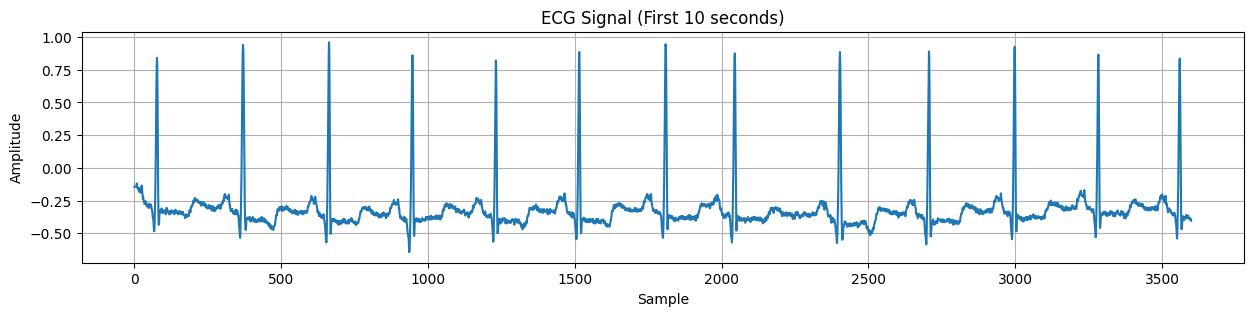

Total number of samples: 650000
Feature dimension: 1


In [11]:
# This cell loads ECG data from record 100 in the MIT-BIH Arrhythmia Database using the wfdb library.
# No windowing or segmentation is applied: the raw signal is reshaped so that each time point becomes an individual instance.
# This design supports the core assumption of the Modal Isolation Forest (MIF): 
# contextual relationships (like temporal or spatial) can be learned directly through modality-aware splitting.

import wfdb
import numpy as np
import matplotlib.pyplot as plt

# Download and load record 100 from the MIT-BIH dataset (including signal and annotations)
record = wfdb.rdrecord('100', pn_dir='mitdb')       # Signal data (MLII and V5 channels)
annotation = wfdb.rdann('100', 'atr', pn_dir='mitdb')  # Annotations (e.g., beat types and locations)

# Extract the MLII channel (single-lead ECG signal)
signal = record.p_signal[:, 0]

# Plot the first 10 seconds of the ECG signal
# The sampling rate is 360 Hz → 10 seconds = 3600 samples
plt.figure(figsize=(15, 3))
plt.plot(signal[:3600])
plt.title("ECG Signal (First 10 seconds)")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# Reshape the raw ECG signal to a 2D array where each time point is treated as one instance (n, 1)
X = signal.reshape(-1, 1)

# Display basic information about the input matrix
print(f"Total number of samples: {X.shape[0]}")
print(f"Feature dimension: {X.shape[1]}")

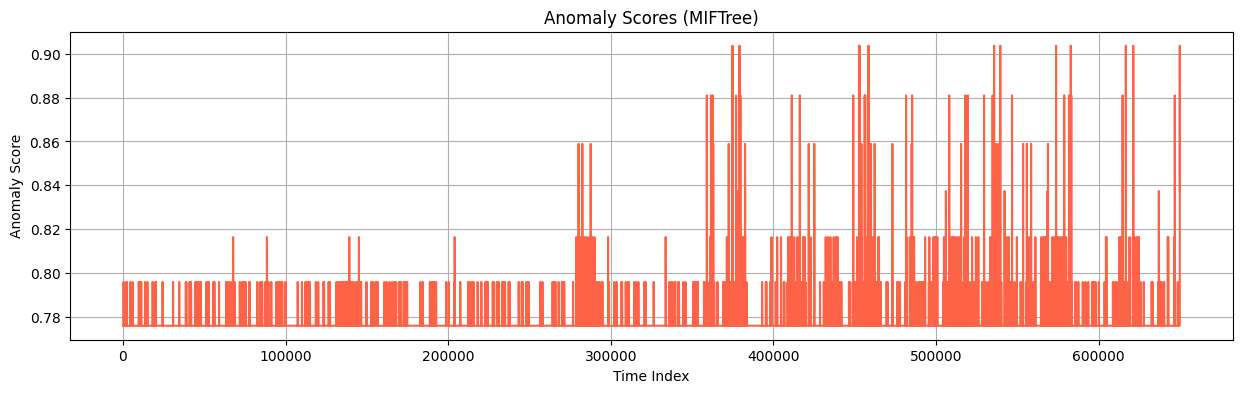

In [13]:
# Build and train a single Modal Isolation Tree
np.random.seed(42)  # Set a random seed for reproducibility
tree = MIFTree(max_depth=10, min_size=1)
tree.fit(X)  # Train the tree using the input signal (each time point is one instance)

# Compute anomaly scores for each time point in the signal
# The score is based on how easily a point is isolated in the tree
scores = tree.anomaly_score(X)

# Visualize the anomaly scores over time
# Higher scores indicate more anomalous (i.e., quickly isolated) points
plt.figure(figsize=(15, 4))
plt.plot(scores, color="tomato")
plt.title("Anomaly Scores (MIFTree)")
plt.xlabel("Time Index")
plt.ylabel("Anomaly Score")
plt.grid(True)
plt.show()

First 10 scores: [0.7144641  0.68372454 0.68372454 0.68372454 0.68372454 0.68372454
 0.68372454 0.68372454 0.68372454 0.71797443]
Score range: 0.6837245360078278 to 0.8996411514426246


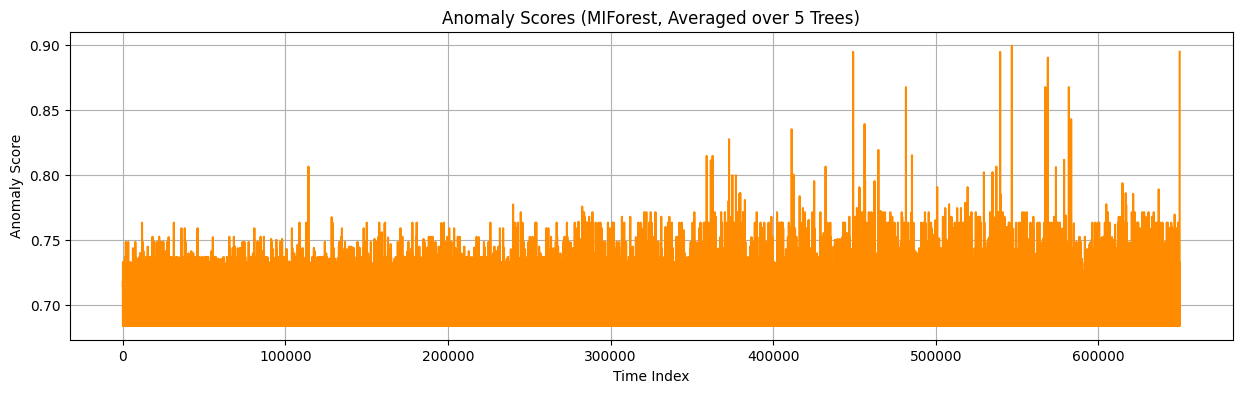

In [15]:
# Fix randomness for reproducibility
np.random.seed(42)

# Create and train the forest
forest = MIForest(n_trees=5, max_depth=15, min_size=5, seed=42)
forest.fit(X)

# Compute anomaly scores first
forest_scores = forest.anomaly_score(X)

# Then validate them
if np.any(np.isnan(forest_scores)):
    raise ValueError("Anomaly scores contain NaN values. Check the tree logic or projection steps.")

# Print some stats
print("First 10 scores:", forest_scores[:10])
print("Score range:", forest_scores.min(), "to", forest_scores.max())

# Plot the scores
plt.figure(figsize=(15, 4))
plt.plot(forest_scores, color="darkorange")
plt.title("Anomaly Scores (MIForest, Averaged over 5 Trees)")
plt.xlabel("Time Index")
plt.ylabel("Anomaly Score")
plt.grid(True)
plt.show()

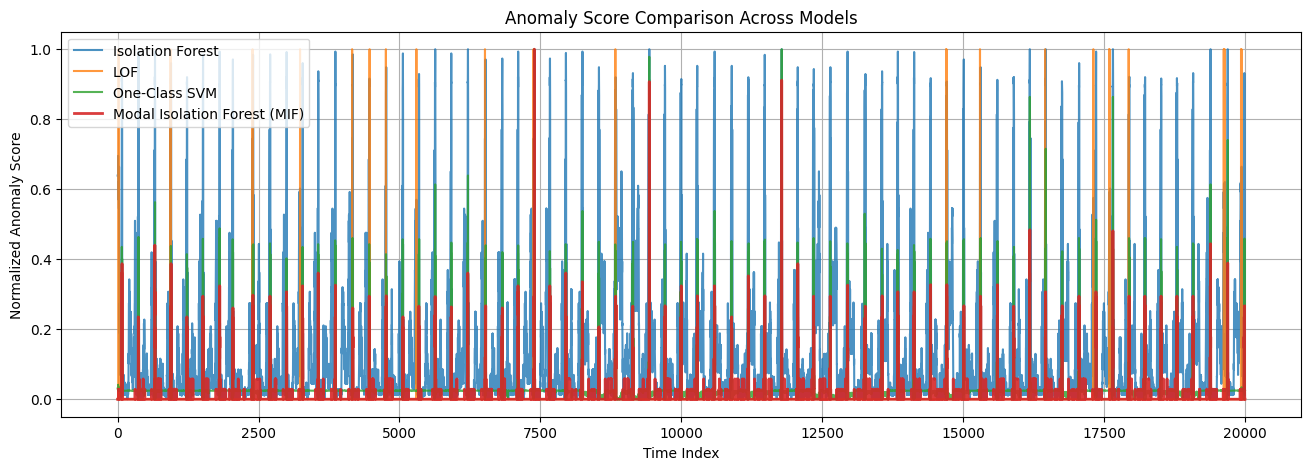

In [17]:
# This cell benchmarks the Modal Isolation Forest (MIF) against three classical anomaly detection models:
# Isolation Forest (iForest), Local Outlier Factor (LOF), and One-Class SVM (OC-SVM).
# All models are trained and evaluated on the same ECG segment, and their anomaly scores are normalized to [0, 1] for visual comparison.

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler

# Use the same data slice for all models
X_small = X[:20000]

# 1. Isolation Forest (scikit-learn)
iso_model = IsolationForest(random_state=42, contamination='auto')
iso_model.fit(X_small)
iso_scores = -iso_model.decision_function(X_small)  # higher = more anomalous

# 2. Local Outlier Factor
lof_model = LocalOutlierFactor(n_neighbors=20, novelty=True)
lof_model.fit(X_small)
lof_scores = -lof_model.decision_function(X_small)

# 3. One-Class SVM
svm_model = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
svm_model.fit(X_small)
svm_scores = -svm_model.decision_function(X_small)

# 4. Modal Isolation Forest 
mif = MIForest(
    n_trees=10,
    max_depth=8,
    min_size=5,
    modality_probs=[0.4, 0.2, 0.4],  # X, EQ, Y acordingly
    seed=42
)

mif.fit(X_small)
mif_scores = mif.anomaly_score(X_small)

# Normalize all scores to [0, 1] for fair comparison
scaler = MinMaxScaler()
all_scores = scaler.fit_transform(np.vstack([
    iso_scores,
    lof_scores,
    svm_scores,
    mif_scores
]).T)  # shape: (n_samples, 4)

# Plot all models
plt.figure(figsize=(16, 5))
plt.plot(all_scores[:, 0], label="Isolation Forest", alpha=0.8)
plt.plot(all_scores[:, 1], label="LOF", alpha=0.8)
plt.plot(all_scores[:, 2], label="One-Class SVM", alpha=0.8)
plt.plot(all_scores[:, 3], label="Modal Isolation Forest (MIF)", alpha=0.9, linewidth=2)
plt.title("Anomaly Score Comparison Across Models")
plt.xlabel("Time Index")
plt.ylabel("Normalized Anomaly Score")
plt.legend()
plt.grid(True)
plt.show()

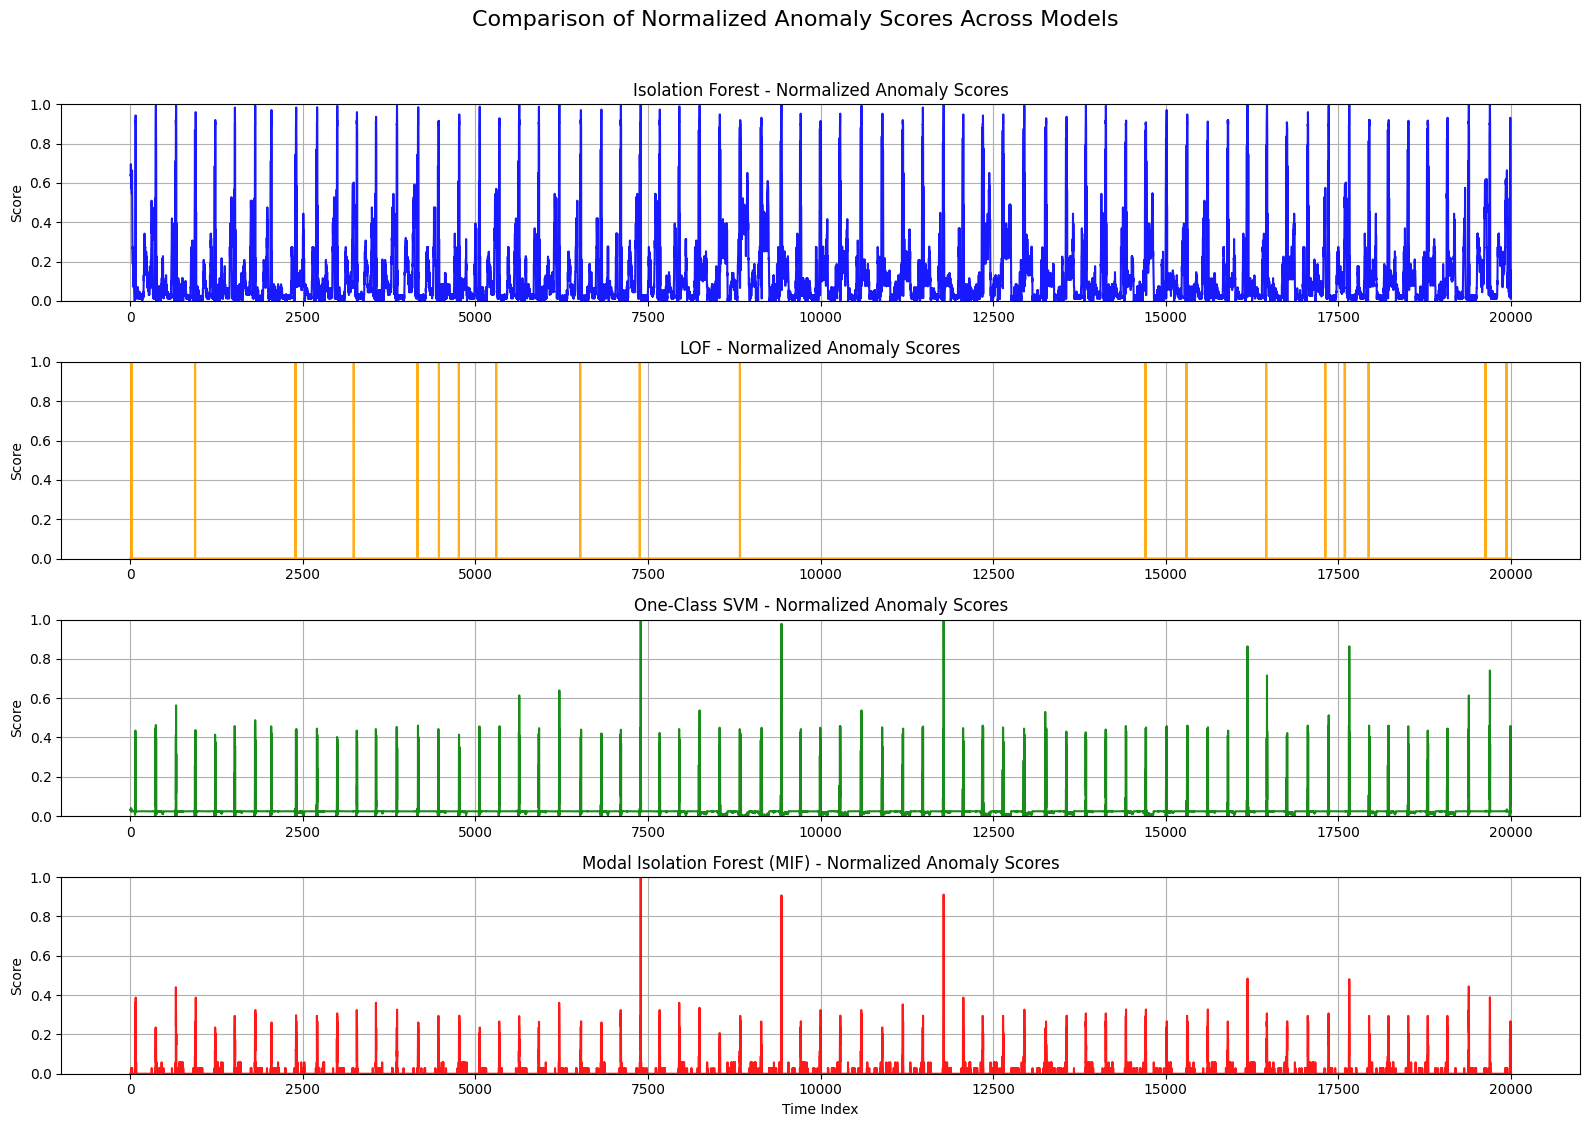

In [19]:
# This cell visualizes the normalized anomaly scores from each model separately using subplots.
# Each subplot allows for a clearer view of how each method behaves over time on the same ECG data.
# The consistent y-axis range (0 to 1) ensures fair visual comparison.

# Define model names and corresponding colors for plotting
models = ['Isolation Forest', 'LOF', 'One-Class SVM', 'Modal Isolation Forest (MIF)']
colors = ['blue', 'orange', 'green', 'red']

# Set the overall figure size
plt.figure(figsize=(16, 11))

plt.suptitle("Comparison of Normalized Anomaly Scores Across Models", fontsize=16, y=1.02)

# Plot normalized anomaly scores for each model in a separate subplot
for i in range(4):
    plt.subplot(4, 1, i + 1)
    plt.plot(all_scores[:, i], color=colors[i], alpha=0.9)
    plt.title(f"{models[i]} - Normalized Anomaly Scores")
    plt.ylabel("Score")
    plt.ylim(0, 1)  
    plt.grid(True)
    if i == 3:
        plt.xlabel("Time Index")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

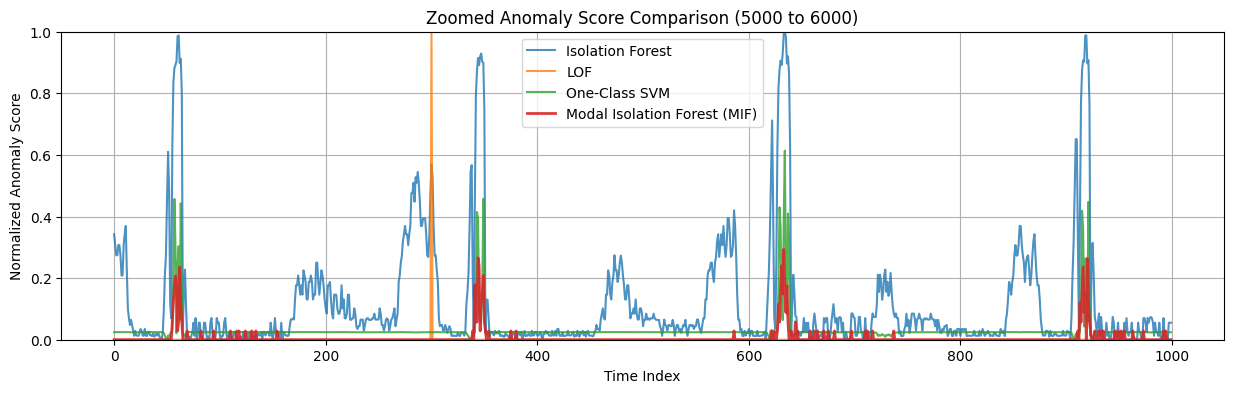

In [21]:
# Zoom into a selected region of the signal
start, end = 5000, 6000  

plt.figure(figsize=(15, 4))
plt.plot(all_scores[start:end, 0], label="Isolation Forest", alpha=0.8)
plt.plot(all_scores[start:end, 1], label="LOF", alpha=0.8)
plt.plot(all_scores[start:end, 2], label="One-Class SVM", alpha=0.8)
plt.plot(all_scores[start:end, 3], label="Modal Isolation Forest (MIF)", alpha=0.9, linewidth=2)

plt.title(f"Zoomed Anomaly Score Comparison ({start} to {end})")
plt.xlabel("Time Index")
plt.ylabel("Normalized Anomaly Score")
plt.ylim(0, 1)  # Optional: standardize the y-axis
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# This function evaluates a model's performance by sweeping over multiple threshold percentiles.
# For each threshold, it converts anomaly scores to binary predictions and computes the F1-score.
# The function identifies the threshold that yields the best F1 and plots the trend for analysis.

from sklearn.metrics import f1_score

# This function evaluates the F1-score over a range of threshold percentiles
def threshold_sweep(model_scores, annotation, n_samples=20000, percentiles=range(85, 100)):
    y_true = np.zeros(n_samples)
    for i in annotation.sample:
        if i < n_samples:
            y_true[i] = 1

    f1_scores = []

    # Loop through given percentiles to determine best threshold
    for p in percentiles:
        threshold = np.percentile(model_scores, p)
        y_pred = (model_scores > threshold).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        f1_scores.append(f1)
        

    # Plot F1-score as a function of threshold percentile
    plt.figure(figsize=(10, 4))
    plt.plot(percentiles, f1_scores, marker='o', color='crimson')
    plt.title("F1-score vs Threshold Percentile (Ultimate MIF)")
    plt.xlabel("Threshold Percentile")
    plt.ylabel("F1-score")
    plt.grid(True)
    plt.show()

     # Print the best performing threshold percentile and corresponding F1-score
    best_p = percentiles[np.argmax(f1_scores)]
    best_f1 = max(f1_scores)
    print(f"Best Threshold Percentile: {best_p}")
    print(f"Best F1-score: {best_f1:.4f}")

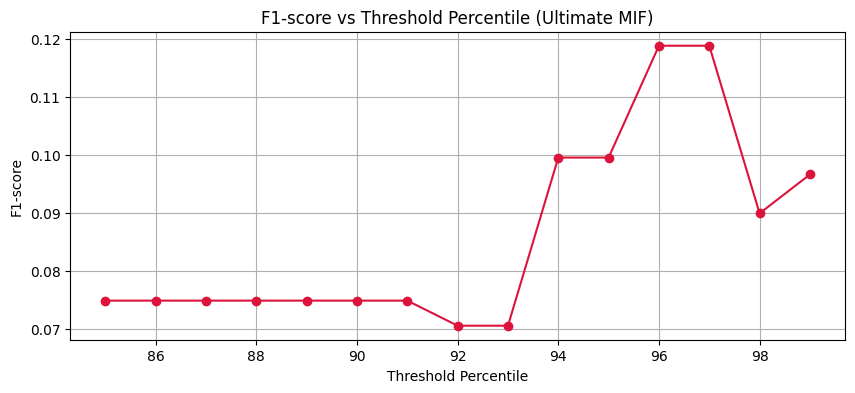

Best Threshold Percentile: 96
Best F1-score: 0.1189


In [25]:
threshold_sweep(all_scores[:, 3], annotation, n_samples=20000)

In [27]:
# This function performs a grid search over the number of trees and tree depth 
# to optimize the performance of the Modal Isolation Forest (MIForest).
# For each parameter combination, it computes normalized anomaly scores,
# applies a fixed threshold, and evaluates F1-score based on annotated ground truth.
# The best-performing configuration is printed and returned.

from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler

# This function performs a grid search over number of trees and max depth for MIForest
def sweep_mif_params(X, annotation, n_samples=20000,
                     tree_range=[10, 25, 50, 75, 100],
                     depth_range=[8, 10, 12, 14, 16],
                     modality_probs=[0.1, 0.8, 0.1],
                     threshold_percentile=99,
                     seed=None):
    
    # Create ground truth label vector from annotations
    y_true = np.zeros(n_samples)
    for i in annotation.sample:
        if i < n_samples:
            y_true[i] = 1  # Mark annotated anomaly points

    best_f1 = -1              # Track best F1-score
    best_params = None        # Track parameters giving the best F1-score

    results = []              # Store all results (n_trees, max_depth, F1)

    # Grid search over number of trees and max depth
    for n_trees in tree_range:
        for max_depth in depth_range:
            mif = MIForest(
                n_trees=n_trees,
                max_depth=max_depth,
                min_size=5,
                modality_probs=modality_probs,
                seed=seed
            )
            mif.fit(X)  # Train the MIForest
            scores = mif.anomaly_score(X)  # Get anomaly scores
            scores_norm = MinMaxScaler().fit_transform(scores.reshape(-1, 1)).flatten()  # Normalize scores to [0, 1]
            
            # Apply threshold and compute F1-score
            threshold = np.percentile(scores_norm, threshold_percentile)
            y_pred = (scores_norm > threshold).astype(int)
            f1 = f1_score(y_true, y_pred, zero_division=0)

            results.append((n_trees, max_depth, f1))  # Store result

            # Update best configuration if current one is better
            if f1 > best_f1:
                best_f1 = f1
                best_params = (n_trees, max_depth)

            print(f"n_trees={n_trees}, max_depth={max_depth} → F1: {f1:.4f}")

    # Print the best configuration found
    print("\n Best Configuration ")
    print(f"n_trees = {best_params[0]}, max_depth = {best_params[1]}, F1-score = {best_f1:.4f}")

    return results, best_params

In [61]:
results, best_params = sweep_mif_params(X_small, annotation, seed=42)

n_trees=10, max_depth=8 → F1: 0.1866
n_trees=10, max_depth=10 → F1: 0.1208
n_trees=10, max_depth=12 → F1: 0.1481
n_trees=10, max_depth=14 → F1: 0.1493
n_trees=10, max_depth=16 → F1: 0.1556
n_trees=25, max_depth=8 → F1: 0.1585
n_trees=25, max_depth=10 → F1: 0.0519
n_trees=25, max_depth=12 → F1: 0.1037
n_trees=25, max_depth=14 → F1: 0.0967
n_trees=25, max_depth=16 → F1: 0.1111
n_trees=50, max_depth=8 → F1: 0.1190
n_trees=50, max_depth=10 → F1: 0.0815
n_trees=50, max_depth=12 → F1: 0.1259
n_trees=50, max_depth=14 → F1: 0.1259
n_trees=50, max_depth=16 → F1: 0.0963
n_trees=75, max_depth=8 → F1: 0.1185
n_trees=75, max_depth=10 → F1: 0.0815
n_trees=75, max_depth=12 → F1: 0.1185
n_trees=75, max_depth=14 → F1: 0.1407
n_trees=75, max_depth=16 → F1: 0.0963
n_trees=100, max_depth=8 → F1: 0.0889
n_trees=100, max_depth=10 → F1: 0.0741
n_trees=100, max_depth=12 → F1: 0.1111
n_trees=100, max_depth=14 → F1: 0.1259
n_trees=100, max_depth=16 → F1: 0.0963

 Best Configuration 
n_trees = 10, max_depth = 8,

In [31]:
# This function sweeps across different modality probability distributions (e.g., X, EQ, Y)
# to identify which configuration yields the highest F1-score for Modal Isolation Forest (MIF).
# For each modality setting, the model is trained, evaluated, and compared using a fixed threshold percentile.
# The best-performing modality distribution is returned.

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
import numpy as np

def sweep_modalities(X, annotation, modality_grid, threshold_percentile=95, n_samples=20000):
    y_true = np.zeros(n_samples)
    for i in annotation.sample:
        if i < n_samples:
            y_true[i] = 1

    best_f1 = -1
    best_probs = None
    results = []

    for probs in modality_grid:
        print(f"Trying modality_probs: {probs}")
        mif = MIForest(
            n_trees=10,
            max_depth=8,
            min_size=10,
            modality_probs=probs,
            seed=42
        )
        mif.fit(X)
        scores = mif.anomaly_score(X)
        scores_norm = MinMaxScaler().fit_transform(scores.reshape(-1, 1)).flatten()
        
        threshold = np.percentile(scores_norm, threshold_percentile)
        y_pred = (scores_norm > threshold).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        print(f"F1-score: {f1:.4f}\n")

        results.append((probs, f1))
        if f1 > best_f1:
            best_f1 = f1
            best_probs = probs

    print(f"Best modality_probs: {best_probs}, F1-score: {best_f1:.4f}")
    return results, best_probs

In [95]:
modality_grid = [
    [0.1, 0.8, 0.1],
    [0.15, 0.7, 0.15],
    [0.2, 0.6, 0.2],
    [0.25, 0.5, 0.25],
    [0.3, 0.4, 0.3],
    [0.33, 0.34, 0.33],
    [0.4, 0.2, 0.4],
    [0.05, 0.9, 0.05]
]

In [97]:
results, best_probs = sweep_modalities(X_small, annotation, modality_grid, threshold_percentile=96)


Trying modality_probs: [0.1, 0.8, 0.1]
F1-score: 0.1380

Trying modality_probs: [0.15, 0.7, 0.15]
F1-score: 0.1039

Trying modality_probs: [0.2, 0.6, 0.2]
F1-score: 0.1058

Trying modality_probs: [0.25, 0.5, 0.25]
F1-score: 0.1096

Trying modality_probs: [0.3, 0.4, 0.3]
F1-score: 0.1157

Trying modality_probs: [0.33, 0.34, 0.33]
F1-score: 0.1335

Trying modality_probs: [0.4, 0.2, 0.4]
F1-score: 0.1156

Trying modality_probs: [0.05, 0.9, 0.05]
F1-score: 0.1208

Best modality_probs: [0.1, 0.8, 0.1], F1-score: 0.1380


In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

def evaluate_models(all_scores, annotation, threshold_percentile=90, n_samples=20000):
    """
    all_scores: shape (n_samples, n_models) — normalized anomaly scores
    annotation: wfdb annotation object (with .sample)
    threshold_percentile: threshold to define 'anomaly' from score
    n_samples: number of time points (should match score length)
    """
    # 1. Ground truth label vector
    y_true = np.zeros(n_samples)
    for i in annotation.sample:
        if i < n_samples:
            y_true[i] = 1  # Mark annotated points as 1 (anomaly)

    # 2. Model names
    model_names = ["Isolation Forest", "LOF", "One-Class SVM", "Modal IF (MIF)"]

    print("Model Evaluation Summary")
    for i, name in enumerate(model_names):
        scores = all_scores[:, i]

        # Compute threshold
        thresh = np.percentile(scores, threshold_percentile)

        # Predict anomalies based on threshold
        y_pred = (scores > thresh).astype(int)

        # Compute metrics
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        print(f"\n{name}")
        print(f"  Threshold: {thresh:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1-score:  {f1:.4f}")


In [37]:
from sklearn.preprocessing import MinMaxScaler

# 1. Initialize a strong MIForest configuration (favoring EQ modality)
mif = MIForest(
    n_trees=10,                      # Number of trees in the forest
    max_depth=8,                     # Maximum depth of each tree
    min_size=5,                      # Minimum number of samples to split
    modality_probs=[0.1, 0.8, 0.1],  # Modalities: 10% X, 80% EQ, 10% Y
    seed=42                          # Seed for reproducibility
)

# 2. Train the model on the ECG data
mif.fit(X_small)

# 3. Compute anomaly scores for each time point
mif_scores = mif.anomaly_score(X_small)

# 4. Normalize the scores to the [0, 1] range for fair comparison
mif_scores_norm = MinMaxScaler().fit_transform(mif_scores.reshape(-1, 1))

# 5. Update the MIF column in the all_scores matrix
all_scores[:, 3] = mif_scores_norm[:, 0]

# 6. Final evaluation: compute F1-score, precision, recall using a fixed threshold percentile (e.g., 96th percentile)
evaluate_models(all_scores, annotation, threshold_percentile=96, n_samples=20000)

Model Evaluation Summary

Isolation Forest
  Threshold: 0.6762
  Precision: 0.0866
  Recall:    0.9857
  F1-score:  0.1592

LOF
  Threshold: 0.0000
  Precision: 0.0889
  Recall:    0.5286
  F1-score:  0.1523

One-Class SVM
  Threshold: 0.0270
  Precision: 0.0806
  Recall:    0.9143
  F1-score:  0.1481

Modal IF (MIF)
  Threshold: 0.0556
  Precision: 0.0846
  Recall:    0.9571
  F1-score:  0.1555
